In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
%matplotlib inline

### Load data (pre-processed in clean.ipynb) and define useful constants

In [3]:
# load data
res = pd.read_csv("results/results_cleaned.csv")

# required fields
ids = ['timestamp','postId','workerId','mode']

# timing
time_diff = ['timestamp','postId','workerId','mode','time_diff_build', 'time_diff_experiment',
       'time_diff_explore', 'time_diff_strategy', 'time_diff_training']

modes = ["List", "Category", "Pairwise"]

### Overall time spent by workers and pricing

In [4]:
price_per_hit = 1.5

def hourly_rate(x):
    return (60/x)*price_per_hit

In [5]:
#average time 
print('average hourly rate', hourly_rate(res['time_diff_experiment'].mean()/1000/60))
print('median hourly rate', hourly_rate(res['time_diff_experiment'].median()/1000/60))
print('maximum hourly rate', hourly_rate(res['time_diff_experiment'].min()/1000/60))
print('minimum hourly rate', hourly_rate(res['time_diff_experiment'].max()/1000/60))

average hourly rate 18.68087194507324
median hourly rate 20.575308486743218
maximum hourly rate 71.7693810555
minimum hourly rate 8.69877588893


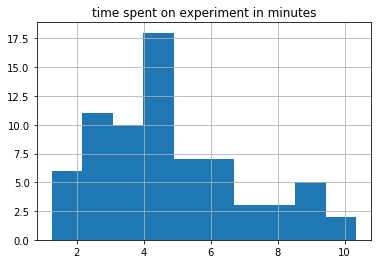

In [9]:
t = res[time_diff].dropna(subset=['time_diff_experiment'])
t['time_diff_experiment'] = t['time_diff_experiment']/1000/60
t.hist('time_diff_experiment')
plt.title("time spent on experiment in minutes")
plt.savefig("results/time_hist.png")

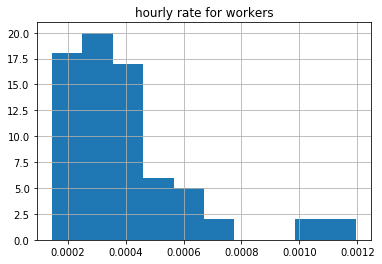

In [10]:
t = res[time_diff].dropna(subset=['time_diff_experiment'])
t['time_diff_experiment'] = t['time_diff_experiment'].map(hourly_rate)
t.hist('time_diff_experiment')
plt.title("hourly rate for workers")
plt.savefig("results/hourly_hist.png")

In [11]:
# compute bootstrapped confidence interval
def bootstrap_mean(data, n_bootstraps):
    bootstraps = []
    for i in range(n_bootstraps):
        # Sample with replacement from data
        bootstraps.append(resample(data).mean())
    return pd.Series(bootstraps)

In [19]:
def confidence_plot_time(df, t, title, filename):

    # sum the times for all sessions for each worker
    times = df.drop_duplicates(subset=['workerId', t]).groupby(['workerId','mode']).sum()
    times = times.reset_index()
    times[t] = times[t]/1000/60

    boot = pd.DataFrame()
    for m in modes:
        boot[m]=bootstrap_mean(times[times["mode"] == m][t], 1000)

    mean = boot.mean()
    err = []
    err.append((boot.apply(lambda x : np.percentile(x, (5))) - mean).abs())
    err.append(boot.apply(lambda x : np.percentile(x, (95))) - mean)

    plt.errorbar(mean, [0,1,2], xerr=err, fmt='o-',linestyle='none', ecolor=['red','blue','green'], elinewidth=3, markersize=7 )
    plt.yticks([0,1,2], mean.index, size='large')
    plt.title(title, size='x-large')
    plt.savefig(filename, bbox_inches='tight')

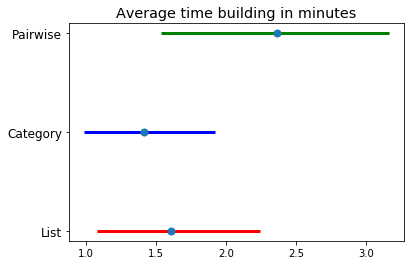

In [20]:
confidence_plot_time(res[['mode','workerId', 'time_diff_build']], 
                     'time_diff_build', 
                     'Average time building in minutes', 
                     'results/build_time.png')

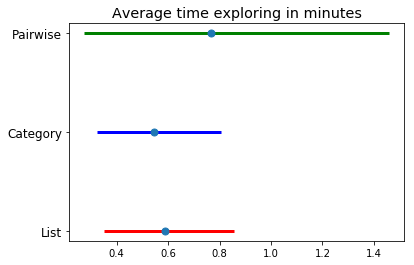

In [21]:
confidence_plot_time(res[['mode','workerId', 'time_diff_explore']], 
                     'time_diff_explore', 
                     'Average time exploring in minutes', 
                     'results/explore_time.png')


AttributeError: module 'seaborn' has no attribute 'plt'

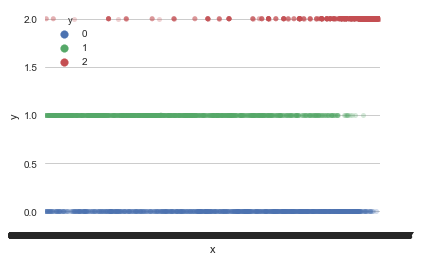

In [35]:
t = 'time_diff_build'
times = res[time_diff].drop_duplicates(subset=['workerId', t]).groupby(['workerId','mode']).sum()
times = times.reset_index()
times[t] = times[t]/1000/60

boot = []
for j,m in enumerate(modes):
    data = times[times["mode"] == m][t]
    for i in range(1000):
        # Sample with replacement from data
        boot.append((resample(data).mean(), j))
b = pd.DataFrame(boot, columns=["x", "y"])

sns.set(style="whitegrid")

# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="x", y="y", hue="y",
              data=b, dodge=True, jitter=True,
              alpha=.25, zorder=1)

# Show the conditional means
# sns.pointplot(x="x", y="y", hue="y",
#               data=b, dodge=.532, join=False, palette="dark",
#               markers="d", scale=.75, ci=None)

# plt.show()
sns.plt.show()
# # Improve the legend 
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[3:], labels[3:], title="species",
#           handletextpad=0, columnspacing=1,
#           loc="lower right", ncol=3, frameon=True)